In [1]:
import sunpy.map
from aiapy.calibrate import register, update_pointing,normalize_exposure
import astropy.units as u
import scipy
import matplotlib.pyplot as plt
import json
import numpy as np
import glob
import time
import os
from datetime import datetime

from pixel_to_world.std_pixel_to_world import std_pixel_to_world
from pixel_to_world.my_pixel_to_world import my_pixel_to_world
from calculate_DN import calculate_DN_4096
from gaussian_fit_aia import gaussian_fit_aia
from error_function import error_function

from constant import wavelength_list_aia
from math import pi

C:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'pixel_to_world'

# a first compare

## read eve

In [14]:
eve_data;

NameError: name 'eve_data' is not defined

In [16]:
with open('mean_dict.json', 'r') as f:
    # Load the JSON data into a Python dictionary
    eve_data = json.load(f)

eve_obs={}
for key, value in eve_data.items():
    eve_obs[int(key)] = float(value)

# # Replace the old dictionary with the new one
eve_obs

{11: -0.004239310241015204,
 12: -0.0042131158770537525,
 13: -0.004203512235761764,
 14: -0.004276632024950544,
 15: -0.004260873667359277,
 16: -0.004259020435920746,
 17: -0.0042300450484304974,
 18: -0.004156687354921473,
 19: -0.004143577588614278,
 21: -0.004321899398107121,
 22: -0.0043340849636201995,
 23: -0.004114510061327792,
 24: -0.0039640485620751065,
 25: -0.003756361418972176,
 26: -0.003832701557165308,
 27: -0.003807650878457025,
 28: -0.004021214325909739,
 29: -0.003969154104499495,
 31: -0.004110962837192034,
 32: -0.004263682049419515,
 33: -0.004517635314023494,
 34: -0.004569844981684668,
 35: -0.004658641042347256,
 36: -0.004533034557539395,
 37: -0.004334751459932562,
 38: -0.004203098692144636,
 39: -0.004044462524213088,
 41: -0.00456272950973613,
 42: -0.004872630679152223,
 43: -0.004929808511555223,
 44: -0.0049640461821347515,
 45: -0.00489309549217154,
 46: -0.004855955084931196,
 47: -0.004665701048395476,
 48: -0.0046213023682781795,
 49: -0.00478800

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


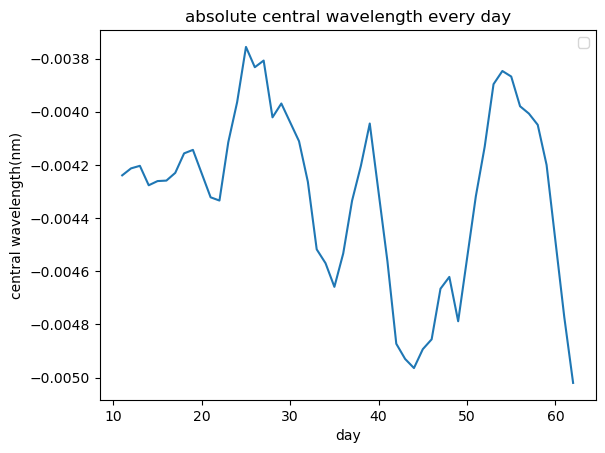

In [17]:
fig,ax=plt.subplots()
ax.plot(eve_obs.keys(),eve_obs.values())
ax.set_title('absolute central wavelength every day')

ax.set_xlabel('day')
ax.set_ylabel('central wavelength(nm)')
ax.legend()

## read aia

In [2]:
aia_adjusted_files=sorted(glob.glob('data/AIA/*adjusted.fits'))
aia_adjusted_maps=sunpy.map.Map(aia_adjusted_files)
irradiance=np.zeros((len(aia_adjusted_maps),len(wavelength_list_aia)))
correction=np.zeros(len(aia_adjusted_maps))

In [3]:
for i in range(len(aia_adjusted_maps)):
    irradiance[i]=calculate_DN_4096(aia_adjusted_maps[i])
    correction[i]=gaussian_fit_aia(wavelength_list_aia,irradiance[i])

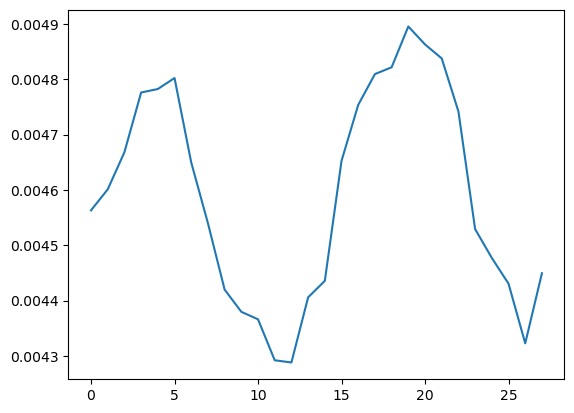

In [4]:
fig,ax=plt.subplots()
ax.plot(correction)

### extract time from map

In [5]:
aia_adjusted_maps[0].meta['t_obs']

'2011-02-03T00:04:09.57Z'

In [6]:
dt = datetime.strptime(aia_adjusted_maps[0].meta['t_obs'], '%Y-%m-%dT%H:%M:%S.%fZ')

# Extract the day of the year from the datetime object
day_of_year = dt.timetuple().tm_yday

In [7]:
time_list=[]

In [8]:
for aia_adjusted_map in aia_adjusted_maps:
    dt = datetime.strptime(aia_adjusted_map.meta['t_obs'], '%Y-%m-%dT%H:%M:%S.%fZ')

    # Extract the day of the year from the datetime object
    day_of_year = dt.timetuple().tm_yday
    time_list.append(day_of_year)

In [9]:
len(time_list)

28

In [10]:
aia_adjusted_map.meta['t_obs']

'2011-03-02T00:04:09.58Z'

In [11]:
len(correction)

28

In [12]:
aia_simu = dict(zip(time_list, correction))
aia_simu;

## Calculate to distance between aia_simu and eve_obs

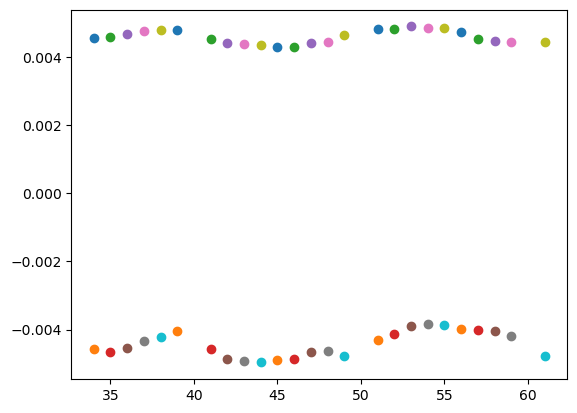

In [18]:
error_func=0
fig,ax=plt.subplots()

for key in aia_simu.keys():
    if key in eve_obs.keys():
        error_func+=(aia_simu[key]-eve_obs[key])**2
        ax.scatter(key,aia_simu[key])
        ax.scatter(key,eve_obs[key])        

In [67]:
def f(a):
    print(a)

In [71]:
error = 0
for key in aia_simu.keys():
    if key in eve_obs.keys():
        error += (aia_simu[key]-eve_obs[key])**2
error

0.0019163293763551457

# Gradient Descent Visualization

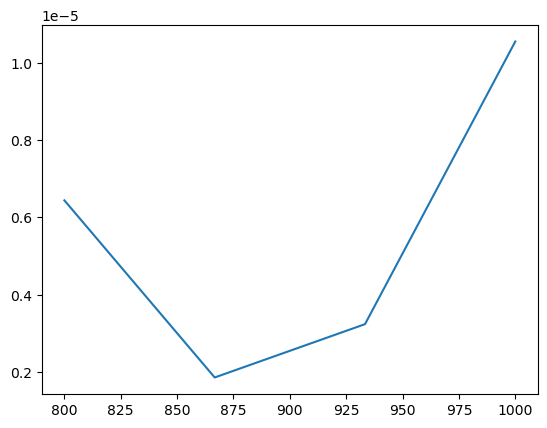

In [21]:
# Fix values of b and c
b = 0.91
c = -9e-03

# Define values of a to evaluate
a_vals = np.linspace(800, 1000, 4)

# Evaluate function at each value of a
f_vals = [error_function((a, b, c)) for a in a_vals]

# Plot the results
fig,ax=plt.subplots()
ax.plot(a_vals,f_vals)

## Time of each function evaluation
160~170s   一次函数求值

In [19]:
def func_evaluation():
    x0 = np.array([ 9e+02,  9e-01, -9e-03])
    error_function(x0)
    

start=time.time()
func_evaluation()    
end=time.time()
end-start

171.58220672607422

### read eve json data

In [9]:
def read_eve():
    with open('mean_dict.json', 'r') as f:
        # Load the JSON data into a Python dictionary
        eve_data = json.load(f)

    eve_obs = {}
    for key, value in eve_data.items():
        eve_obs[int(key)] = float(value)
    
    
start=time.time()
read_eve()    
end=time.time()
end-start

0.0009074211120605469

### read level1.5 fits

In [14]:
def read_aia():
    aia_adjusted_files = sorted(glob.glob('data/AIA/*adjusted.fits'))
    aia_adjusted_maps = sunpy.map.Map(aia_adjusted_files)
    irradiance = np.zeros((len(aia_adjusted_maps), len(wavelength_list_aia)))
    wavelength_correction = np.zeros(len(aia_adjusted_maps))
    
start=time.time()
read_aia()    
end=time.time()
end-start    

0.1984848976135254

### process one image

In [16]:
aia_adjusted_files = sorted(glob.glob('data/AIA/*adjusted.fits'))
aia_adjusted_maps = sunpy.map.Map(aia_adjusted_files)

In [18]:
start=time.time()
calculate_DN_4096(aia_adjusted_maps[0],)
end=time.time()
end-start

6.854181289672852

### fit profiles

In [22]:
aia_adjusted_files = sorted(
    glob.glob('data/AIA/*adjusted.fits'))

if not aia_adjusted_files:
    raise ValueError(
        "No files found with the pattern 'data/AIA/*adjusted.fits'")


aia_adjusted_maps = sunpy.map.Map(aia_adjusted_files)
irradiance = np.zeros((len(aia_adjusted_maps), len(wavelength_list_aia)))
wavelength_correction = np.zeros(len(aia_adjusted_maps))

start=time.time()
for i in range(len(aia_adjusted_maps)):
    irradiance[i] = calculate_DN_4096(aia_adjusted_maps[i])
    
    
    
end=time.time()
end-start


179.8476152420044

In [26]:
start=time.time()

for i in range(len(aia_adjusted_maps)):
    wavelength_correction[i] = gaussian_fit_aia(wavelength_list_aia,
                                            irradiance[i])

end=time.time()
end-start

0.08934664726257324